# Coherence of HD20794: RV & H$\alpha$

This coherence of HARPS data was an endeavor to substantiate the presence of relevant planet signals for the high, proper-motion G-type star HD 20794.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.timeseries import LombScargle
from NWelch.TimeSeries import TimeSeries
import NWelch.Bivariate as Bi
from scipy.stats import chi2

### Fonts and Sizes

Here we keep variables to have consistent fonts and plot sizes throughout this analysis. 

In [2]:
title_font = 18
label_font = 14
text_font = 12
figsize = (9, 5)

### HD20794 Dataset

The data table for HD20794's star activity indicators reported by <a href="https://www.aanda.org/articles/aa/pdf/2017/09/aa30406-17.pdf">Feng et al. (2017)</a>.

In [3]:
data = pd.read_csv('HD20794_HARPS_Feng17.txt', delim_whitespace=True, comment='#')
data

RJD       RV     e_RV       BIS     FWHM   Halpha  logR'(HK)  \
0     53571.92932 -3.54130  0.38257 -41.67402  6.38962  0.16833    0.96511   
1     53571.93408 -3.76917  0.41364 -41.01080  6.39146  0.16774    0.96602   
2     53571.93854 -4.43531  0.39294 -41.18059  6.39094  0.16735    0.96642   
3     53571.94239 -4.86209  0.38001 -41.47111  6.38986  0.16692    0.96633   
4     53571.94634 -3.12528  0.39686 -41.93214  6.38907  0.16795    0.96531   
...           ...      ...      ...       ...      ...      ...        ...   
4878  56538.88169 -3.33677  0.32452 -42.40044  6.40951  0.16493    0.96819   
4879  56564.76211 -3.41550  0.28242 -43.30241  6.41245  0.16540    0.96833   
4880  56564.76479 -3.97736  0.27438 -42.41135  6.41290  0.16586    0.96900   
4881  56564.76738 -3.53729  0.29427 -40.30742  6.41489  0.16642    0.96906   
4882  56564.77014 -4.58082  0.29369 -42.38762  6.41571  0.16585    0.96928   

         NaD1     NaD2   3AP2-1  ...   6AP5-4   6AP6-5   9AP2-1   9AP3-2  \
0     0.70038  0.49035  3.39352  ...  3.07913  2.13056 -2.25731  1.68105   
1     0.70225  0.49138  1.93219  ... -1.04907  4.48251  0.41171  0.28990   
2     0.70151  0.49181  3.67808  ...  1.12875  5.23736  0.97792  2.41222   
3     0.70080  0.49251  2.91127  ... -1.31392  6.16297 -1.26338  2.31786   
4     0.70026  0.49187  3.87870  ...  3.14394  1.74174 -1.16608 -0.18713   
...       ...      ...      ...  ...      ...      ...      ...      ...   
4878  0.70184  0.49811  3.37944  ... -0.35830  5.62643  6.20488 -0.68742   
4879  0.70314  0.49066 -0.30794  ...  3.41633  0.55355  0.57263  0.43058   
4880  0.70201  0.48989  0.18912  ...  2.42535 -0.96201  2.17649  0.47312   
4881  0.70254  0.49128  0.87593  ...  0.46555  1.34238  3.76880 -1.86315   
4882  0.70334  0.49029  0.66736  ...  1.60589  1.68373  3.73640  0.58441   

       9AP4-3   9AP5-4   9AP6-5   9AP7-6   9AP8-7   9AP9-8  
0     3.70944 -0.20450 -2.26730  3.35641  0.65005  3.58131  
1     1.32489  1.54338 -1.77583 -1.45835  5.15898  0.83355  
2     1.78039  0.96703  0.16103  0.01386  3.54310  5.73817  
3     0.67180  1.91097  0.44848 -2.04767  3.62819  4.24236  
4     4.04659  0.47915 -0.73155  2.66149 -0.43096  4.67923  
...       ...      ...      ...      ...      ...      ...  
4878  3.68681  0.56467 -3.11838  0.73634  1.88982  4.33900  
4879 -0.01826 -1.58113  1.41791  2.73226 -3.13380  7.01151  
4880 -0.44202 -0.48194  1.35256  1.89994 -3.40059  4.64229  
4881  0.74373  0.07357  1.38032 -0.28740  0.36095  2.30413  
4882  0.10283 -1.13257  1.70455  1.29643 -2.43766  7.02334  

[4883 rows x 24 columns]

### Stellar signals

These are variables holding the periods for a number of planets, with some being possible signals for planets. Specifically, planets c, f, and g are possible planet signals. These are found in the paper linked above. Planet d has the variable <tt>pld</tt> due to conflicts with the import of pandas.

In [4]:
pb = 18.33
pc = 43.17
pld = 88.90
pe = 147.02
pf = 331.41
pg = 11.86

### Functions & Variables

Below are functions and variables that are used throughout the notebook. The first code cell contains variables used in the following functions and contains the relevant planet signals from the previous code cell.

The <tt>freq_vlines</tt> function is for creating vertical lines at the proper positions for the each stellar signal. 

The <tt>freq_vlines_text</tt> function is for adding text boxes below each vertical made by the previous function to make it clear what signal belongs to what vertical line.

The <tt>rayleigh_shading</tt> function is for creating a filled-in area that represents the Rayleigh resolution. Stellar signals within another stellar signal's Rayleigh resolution would then be indistinguishable. The 'maximum' and 'minimum' variables are used to control how the shaing is positioned within the plot, like if it would stretch down the whole plot where the shading applies.

The <tt>threshold_peaks</tt> functions identifies any peaks within a select False Alarm Percent (FAP) threshold and create a vertical line at each individual peak found. The possible FAP thresholds are 5%, 1%, and 0.1%, each inputted as "coh_prob_5", "coh_prob_1", and "coh_prob_01". The function also has the capability of saving the array of the peaks into a file, as long as a passed file_name variable is included when calling the function.

In [5]:
planets = [1/pb, 1/pc, 1/pld, 1/pe, 1/pf, 1/pg]
planet_labels = ['b (1/18.33)', 'c (1/43.17)', 'd (1/88.90)', 'e (1/147.02)', 'f (1/331.41)', 'g (1/11.86)']
planet_letters = ['b', 'c', 'd', 'e', 'f', 'g']
color_array = ['red', 'black', 'green', 'orange', 'purple', 'magenta']
FAP_color_array = ['red', 'blue', 'green']

In [6]:
def freq_vlines():
    for p, p_l, c_a in zip(planets, planet_labels, color_array):
        plt.axvline(p, linestyle='--', color=c_a, alpha=0.7, label=p_l)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [7]:
def freq_vlines_text():
    for p, p_l, c_a in zip(planets, planet_letters, color_array):
        plt.text(p, plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.05, p_l, color=c_a, fontsize=text_font, 
                 verticalalignment='bottom', horizontalalignment='center', 
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

In [8]:
def rayleigh_shading(rayleigh, maximum, minimum):
    for i in planets:
        plt.fill_between([i - rayleigh, i + rayleigh], [minimum,minimum], [maximum, maximum], color='goldenrod', alpha=0.3)

In [9]:
def threshold_peaks(bivar_obj, threshold, rayleigh, file_name=None):
    x = bivar_obj.pow_coh_grid
    y = bivar_obj.coh_transformed
    prob = Bi.ztrans(getattr(bivar_obj, threshold), bivar_obj.Nseg_eff)
    peak = x[y > prob]
    filtered_peaks = peak[peak <= 0.1]

    for i in filtered_peaks:
        plt.axvline(i, alpha=0.3, ls='--')

    if file_name is not None:
        df = pd.DataFrame(filtered_peaks)
        df.to_csv(file_name, index=False, header=False)
    else:
        print("No file name provided. No new file created.")

<font size=10><p style="text-align:center"> RV & H$\alpha$ </font></p>

## RV & H$\alpha$ TimeSeries Objects

Creating TimeSeries objects and outputing various estimates of the Nyquist-like frequency, which is the highest frequency about which your data contain reliable information. The Rayleigh resolution is the lowest frequency about which your time series contains information.

In [47]:
ha = TimeSeries(data['RJD'].to_numpy(), data['Halpha'].to_numpy())
rv = TimeSeries(data['RJD'].to_numpy(), data['RV'].to_numpy(), display_frequency_info=False)

Nyquist frequency from mean dt: 0.81561
Nyquist frequency from 10% trimmed mean dt: 15.88007
Nyquist frequency from 20% trimmed mean dt: 90.33436
Nyquist frequency from median dt: 326.79739
Rayleigh resolution: 0.00033


### Plotting RV & H$\alpha$

Creating scatterplots of each TimeSeries object. We create a scatter plot of the Radial Velocity (RV) data against the Reduced Julian Date (RJD) data, along with error bars for each data point. Creating $\Delta t$ histogram of RV ($\Delta t_{i} = t_{i+1} - t_{i}$). Examining the $\Delta t$ histogram can help you choose a sensible Nyquist-like frequency for your periodograms.

Text(0.5, 1.0, 'RV Histogram')

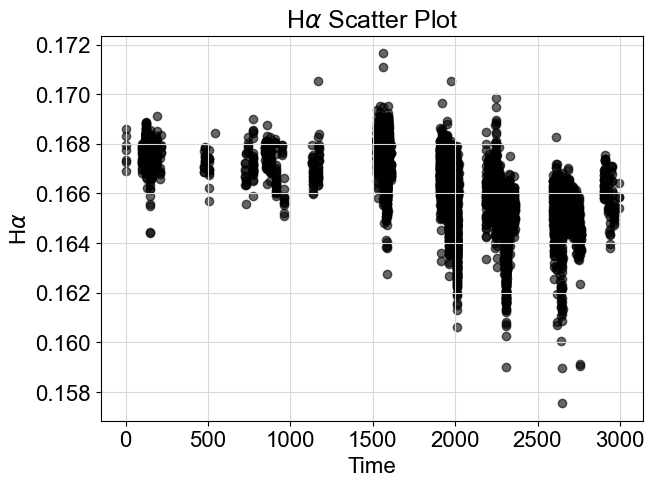

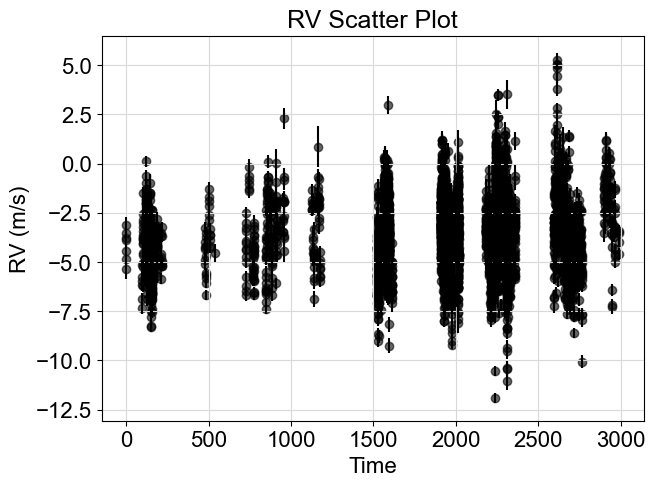

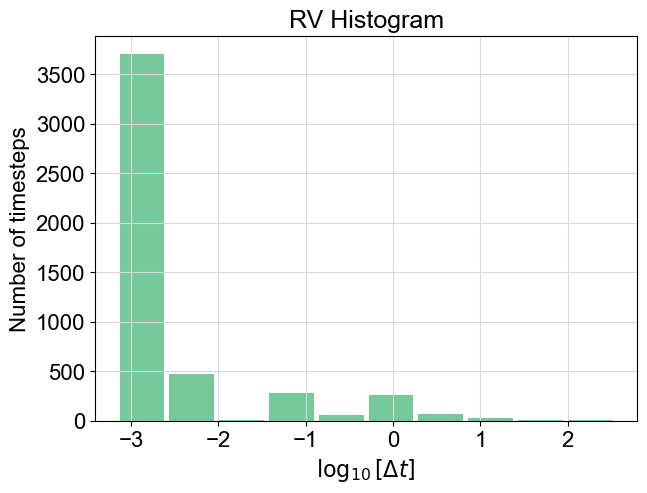

In [11]:
ha.scatterplot(ylabel=r"H$\alpha$")
plt.title(r"H$\alpha$ Scatter Plot", fontsize=title_font)
rv.scatterplot(ylabel="RV (m/s)")
plt.errorbar(data['RJD'] - data['RJD'][0],data['RV'], yerr=data['e_RV'], linestyle='None', color='black')
plt.title(r"RV Scatter Plot", fontsize=title_font)
rv.dthist()
plt.title(r"RV Histogram", fontsize=title_font)

### Frequency grid for the Lomb-Scargle periodogram of RV & H$\alpha$

This software separates frequency-grid construction and periodogram calculation into two different functions. This is so the user has to make a conscious decision about which frequencies it makes sense to probe.

Also running the untapered periodgram of a non-uniform fast Fourier Transform for each TimeSeries objects at 1000 bootstrap iterations.

We use this maximum frequency found in the first cell as the first variable for the frequency_grid function. We take the nyquist frequency from the mean delta t from the TimeSeries objects estimates from previous code cells.

In [38]:
delta_t = data['RJD'][i+1] - data['RJD'][i]
max_freq = 1/(2 * delta_t)
print(max_freq)

129.8701300829722


In [12]:
ha.frequency_grid(0.5, 3)
rv.frequency_grid(0.5, 3)

ha.pow_FT(N_bootstrap=1000)
rv.pow_FT(N_bootstrap=1000)

Iteration 0
Iteration 500
Iteration 0
Iteration 500


### Plot the periodograms of RV & H$\alpha$

The vertical lines mark the signals for six different planets, those being planets b, c, d, e, f, and g. Planets b, d, and e are reported as real signals, while planets c, f, and g are reported as possible planet signals.

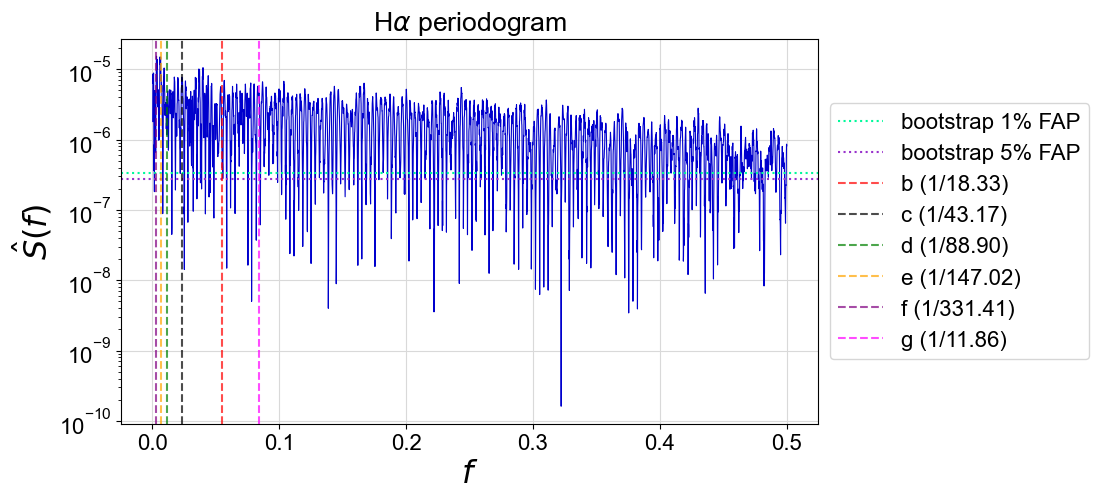

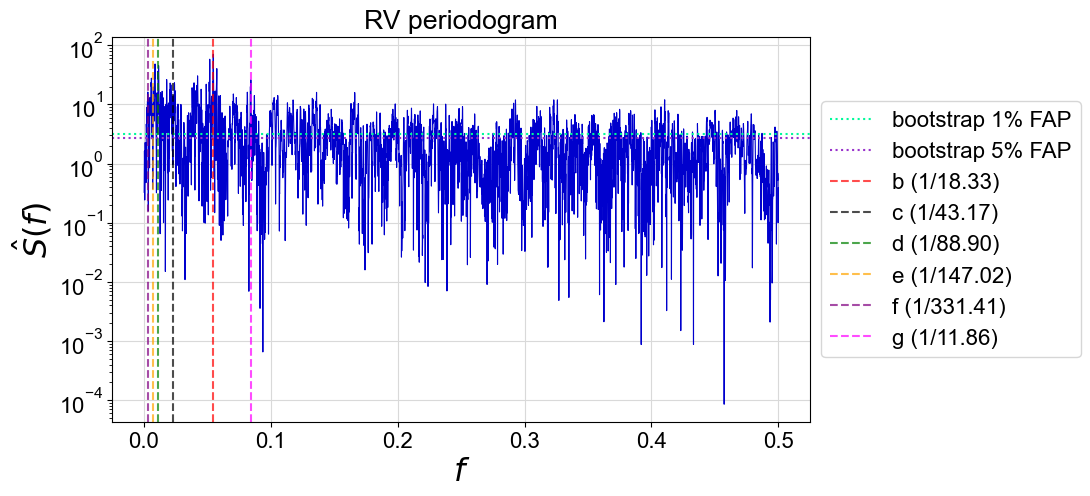

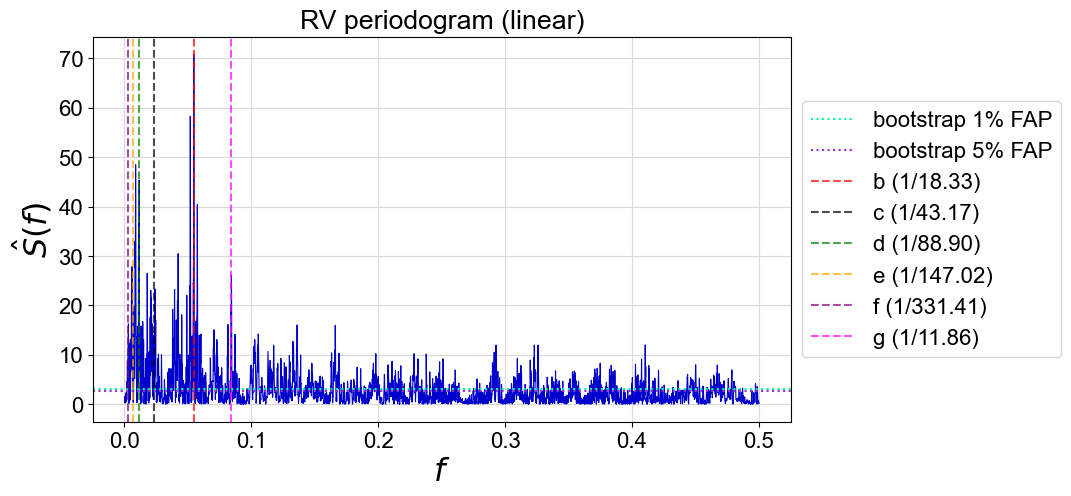

In [13]:
ha.powplot(title=r"H$\alpha$ periodogram")
freq_vlines()
rv.powplot(title='RV periodogram')
freq_vlines()
rv.powplot(title='RV periodogram (linear)', yscale='linear')
freq_vlines()

### Siegel's test for periodicity of RV & H$\alpha$

Here we use the conservative implementation with $\lambda = 0.6$, which is optimized for two periodic signals.

In [14]:
rv.Siegel_test()
ha.Siegel_test()

T statistic: 0.03402
T threshold for rejecting white noise hypothesis at 5% level: 0.00235
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities
T statistic: 0.00313
T threshold for rejecting white noise hypothesis at 5% level: 0.00235
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities


### Start the coherence analysis of RV & H$\alpha$

We start by creating the Bivariate object, which is defined below. We create three different Bivariate objects using the same data to apply a different Welch's segmentation scheme to each one later on. These Bivariate objects are then put into an array for later use as well.

In [15]:
rv_ha_2segs = Bi.Bivariate(data['RJD'].to_numpy(), data['RV'].to_numpy(), data['Halpha'].to_numpy())
rv_ha_3segs = Bi.Bivariate(data['RJD'].to_numpy(), data['RV'].to_numpy(), data['Halpha'].to_numpy())
rv_ha_4segs = Bi.Bivariate(data['RJD'].to_numpy(), data['RV'].to_numpy(), data['Halpha'].to_numpy())
bivar_obj_segs = [rv_ha_2segs, rv_ha_3segs, rv_ha_4segs]

Nyquist frequency from mean dt: 0.81561
Nyquist frequency from 10% trimmed mean dt: 15.88007
Nyquist frequency from 20% trimmed mean dt: 90.33436
Nyquist frequency from median dt: 326.79739
Rayleigh resolution: 0.00033
Nyquist frequency from mean dt: 0.81561
Nyquist frequency from 10% trimmed mean dt: 15.88007
Nyquist frequency from 20% trimmed mean dt: 90.33436
Nyquist frequency from median dt: 326.79739
Rayleigh resolution: 0.00033
Nyquist frequency from mean dt: 0.81561
Nyquist frequency from 10% trimmed mean dt: 15.88007
Nyquist frequency from 20% trimmed mean dt: 90.33436
Nyquist frequency from median dt: 326.79739
Rayleigh resolution: 0.00033


### Finding Segmentation Boundaries

In the following code cells, we try to find the best boundaries to use for different number of segmentations. Three different number of segments were made to be applied to the Bivariate objects created before; one with 2 segments, one with 3 segments, and one with 4 segments. We try to find even splits where each segment will have around an equal number of points to each other. We do this by inputting start and end points for each segment, which are seen in the print statements for each cell. Then, we create a variable to hold an array of each segment, for each different segmenting amount. An array holding each varaible of segmentation arrays is also made.

In [16]:
two_seg1 = np.where(rv_ha_2segs.x_series.t < 2150)[0]
two_seg2 = np.where(rv_ha_2segs.x_series.t > 2150)[0]

print(two_seg1[0], two_seg1[-1])
print(two_seg2[0], two_seg2[-1])

0 2786
2787 4882


In [17]:
three_seg1 = np.where(rv_ha_3segs.x_series.t < 1750)[0]
three_seg2 = np.where((rv_ha_3segs.x_series.t > 1750) & (rv_ha_3segs.x_series.t < 2150))[0]
three_seg3 = np.where(rv_ha_3segs.x_series.t > 2150)[0]

print(three_seg1[0], three_seg1[-1])
print(three_seg2[0], three_seg2[-1])
print(three_seg3[0], three_seg3[-1])

0 1484
1485 2786
2787 4882


In [18]:
four_seg1 = np.where(rv_ha_4segs.x_series.t < 1250)[0]
four_seg2 = np.where((rv_ha_4segs.x_series.t > 1250) & (rv_ha_4segs.x_series.t < 2150))[0]
four_seg3 = np.where((rv_ha_4segs.x_series.t > 2150) & (rv_ha_4segs.x_series.t < 2400))[0]
four_seg4 = np.where(rv_ha_4segs.x_series.t > 2400)[0]

print(four_seg1[0], four_seg1[-1])
print(four_seg2[0], four_seg2[-1])
print(four_seg3[0], four_seg3[-1])
print(four_seg4[0], four_seg4[-1])

0 702
703 2786
2787 4162
4163 4882


In [19]:
two_segs = np.array([[0, 2786], [2787, 4882]])
three_segs = np.array([[0, 1484], [1485, 2786], [2787, 4882]])
four_segs = np.array([[0, 702], [703, 2786], [2787, 4162], [4163, 4882]])
segments = [two_segs, three_segs, four_segs]

### Set up the Welch's segmenting and tapering scheme from RV & H$\alpha$

This is the segmenting and tapering of RV & H$\alpha$. This gives information on Rayleigh resolution and power spectrum resolution unit, related to the spectral window. Multiple instanes of segmentations and tapering are used to view different distributions of spectral windows. Tapering decreases your spectral resolution but helps to supress variance, which is effective for planet searching, but no tapering was used for the segmenting. 

A loop is made to create segmentations for each bivariate object according to the segment array variable created in the previous section. A similar loop is used throughout the notebook. We also create an array for both the best achievable Rayleigh resolution value and the mean 6-db main lobe half width, both array having the values for each segmentation. These can be changed throughout the notebook to see different rayleight resolution shading. For these notebooks, we use the <tt>ideal_rayleigh</tt>, unless stated explicitly on plot.

Number of segments: 2
Segment start and end points: [[   0 2786]
 [2787 4882]]
Effective number of segments: 2.000000
Frequency grid spacing: 0.000083
Minimum 6-dB main lobe half width: 0.000599
Mean 6-dB main lobe half width (1/2 resolution limit): 0.000985
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.000495
Number of segments: 3
Segment start and end points: [[   0 1484]
 [1485 2786]
 [2787 4882]]
Effective number of segments: 3.000000
Frequency grid spacing: 0.000104
Minimum 6-dB main lobe half width: 0.000750
Mean 6-dB main lobe half width (1/2 resolution limit): 0.003729
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.000620
Number of segments: 4
Segment start and end points: [[   0  702]
 [ 703 2786]
 [2787 4162]
 [4163 4882]]
Effective number of segments: 4.000000
Frequency grid spacing: 0.000142
Minimum 6-dB main lobe half width: 0.001031
Mean 6-dB main lobe half width (1/2 resolution limit): 0.003574
Best achievable Rayleigh limit (1/2 

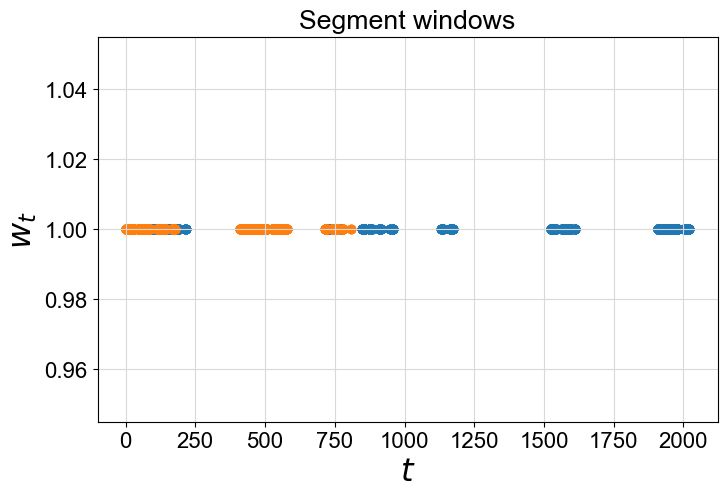

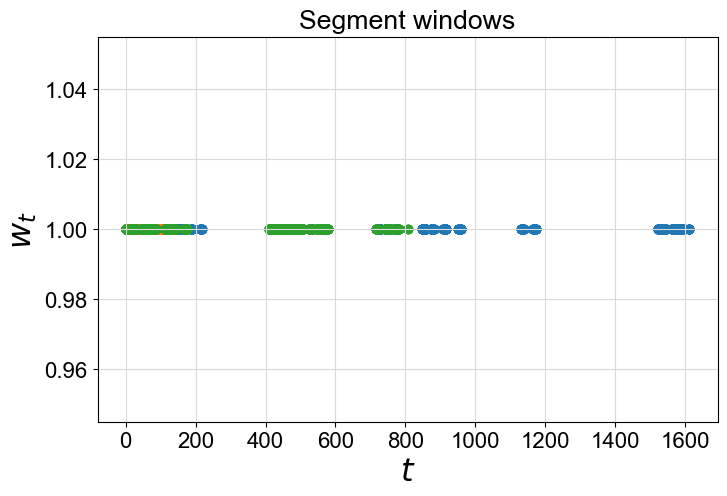

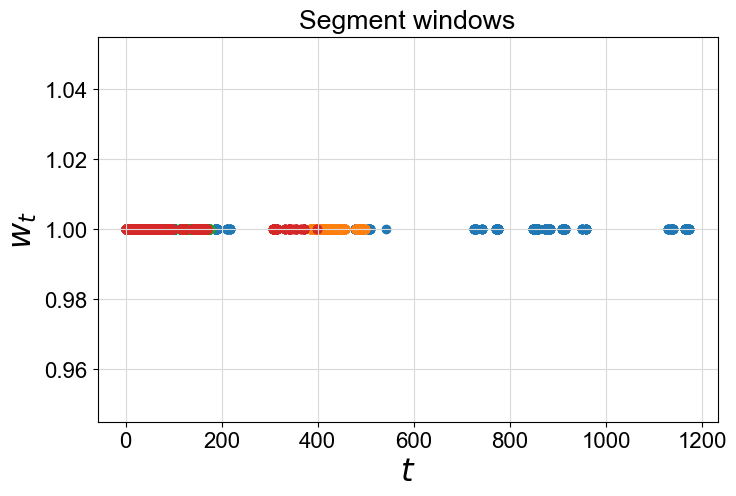

In [20]:
for bivar_objs, segment_arrays in zip(bivar_obj_segs, segments):
    bivar_objs.segment_data(segment_arrays, 0.2, oversample=6, plot_windows=True)
    
ideal_rayleigh = [0.000495, 0.000620, 0.000852]
mean6db_rayleigh= [0.000985, 0.003729, 0.003574]

### Calculating the RV & H$\alpha$ coherence estimate, Welch's power spectrum estimates, and bootstrap false alarm levels

You would want zero background coherence when computing analytical false alarm levels on coherence stimates. boostrap helps with this, as they act as a fialsafe for when the analytical false alarm levels fail, which doesn't happen very often. In calculating the power spectrum estimates, 10000 iterations are used.

In [21]:
for bivar_objs in bivar_obj_segs:
    bivar_objs.Welch_coherence_powspec()
    bivar_objs.Welch_coherence_powspec_bootstrap()

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500
Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500
Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500


### Using Siegel's test on the Welch's power spectrum estimates for RV & H$\alpha$

<tt>Bivariate.Siegel_Welch()<tt> is actually just a wrapper of <tt>TimeSeries.Siegel_test(Welch=True)<tt>.

As expected, the Welch's power spectrum estimates support the hypothesis that both time series are periodic.

In [22]:
for bivar_objs in bivar_obj_segs:
    bivar_objs.Siegel_Welch()

Siegel's test on Sxx:
T statistic: 0.00215
T threshold for rejecting white noise hypothesis at 5% level: 0.00367
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)
Siegel's test on Syy:
T statistic: 0.00000
T threshold for rejecting white noise hypothesis at 5% level: 0.00367
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)
Siegel's test on Sxx:
T statistic: 0.00000
T threshold for rejecting white noise hypothesis at 5% level: 0.00433
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)
Siegel's test on Syy:
T statistic: 0.00000
T threshold for rejecting white noise hypothesis at 5% level: 0.00433
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)
Siegel's test on Sxx:
T statistic: 0.00000
T threshold for rejecting white noise hypothesis at 5% level: 0.00545
Null hypothesis not rejected: This time series could be white noise (or

### Plotting the magnitude-squared coherence estimate from RV & H$\alpha$

The vertical lines show the stellar signals mentioned before, which are signals for planets b, c, d, e, f, and g.

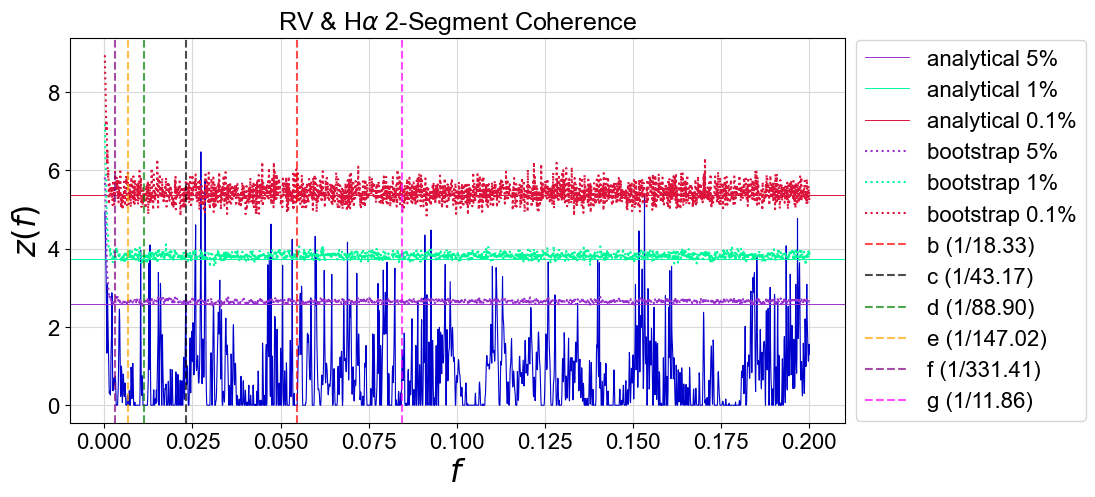

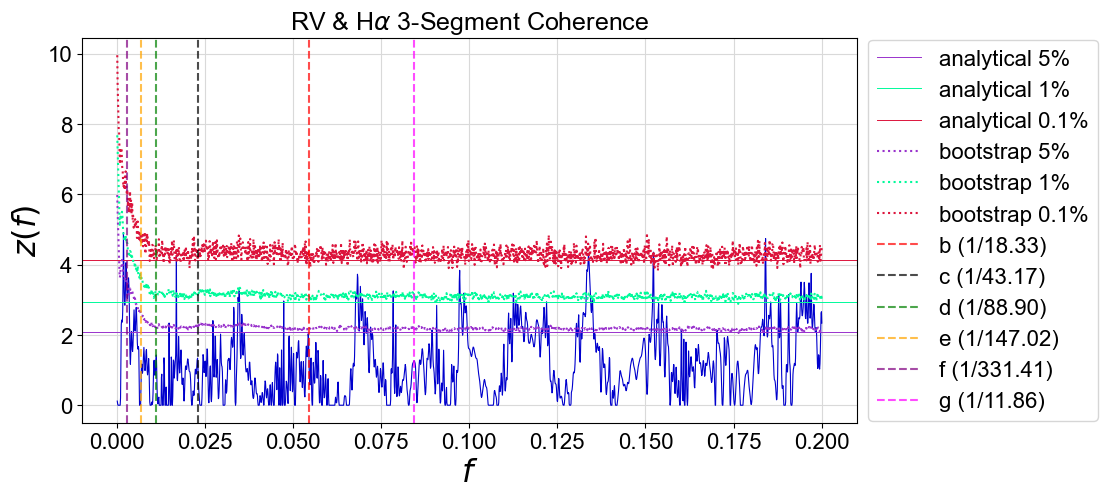

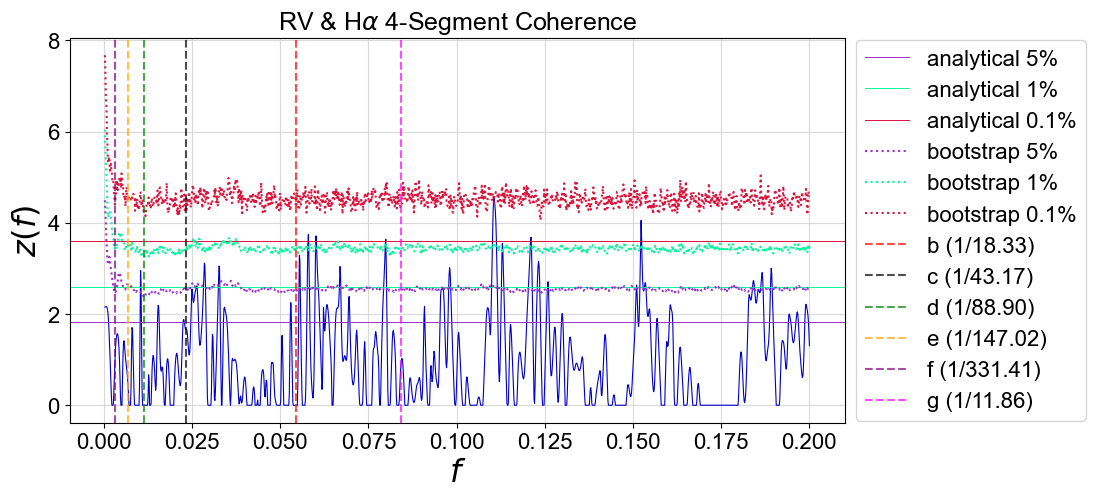

In [23]:
msce_titles = [r"RV & H$\alpha$ 2-Segment Coherence",
               r"RV & H$\alpha$ 3-Segment Coherence",
               r"RV & H$\alpha$ 4-Segment Coherence"]

for bivar_objs, title in zip(bivar_obj_segs, msce_titles):
    bivar_objs.coh_plot(show_theoretical_thresholds=True)
    plt.title(title, fontsize=title_font)
    freq_vlines()

### Plot the transformed coherence estimate $z(f)$ for RV & H$\alpha$

In this plot of the transformed coherence estimate $z(f)$, we can see the stellar signals mentioned before. The code cell results in three plots, one for each different segmentation. These three plots have shading based on the Rayleigh resolution from the segmentation process, with each having a different Rayleigh resolution. This Rayleigh shading can be used to distinguished two signals with a Rayleigh resolution of each other. If two signals are within a Rayleigh resolution of each other, then they are indistinguishable.

No file name provided. No new file created.


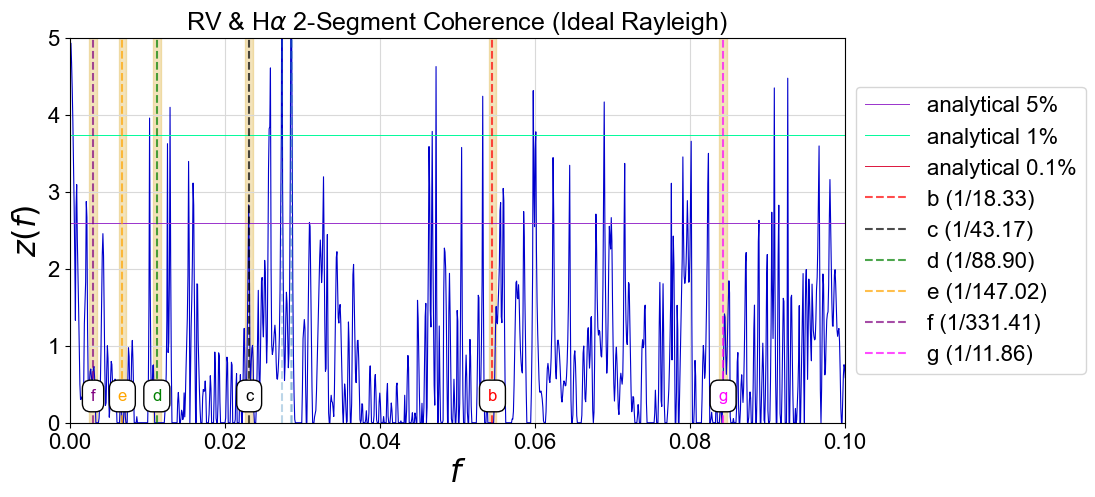

No file name provided. No new file created.


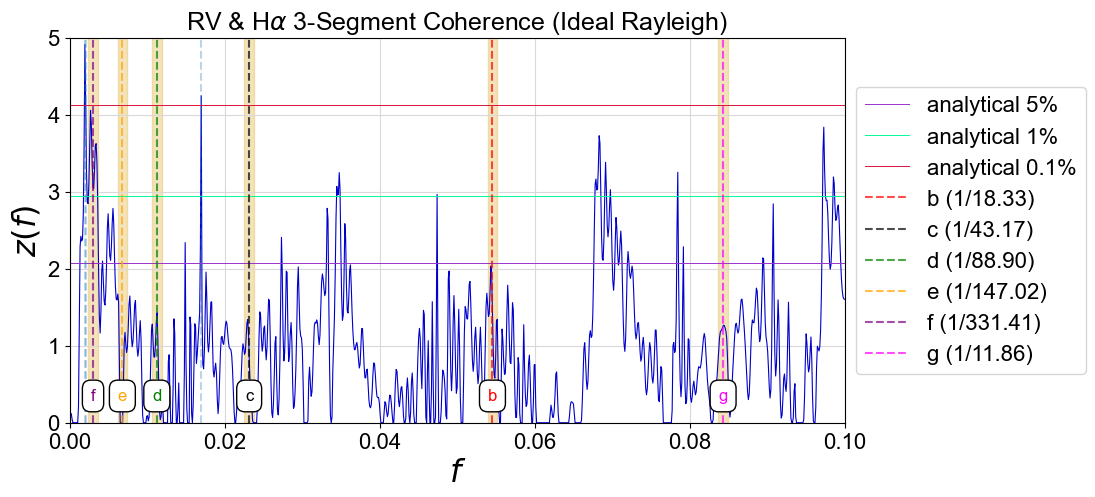

No file name provided. No new file created.


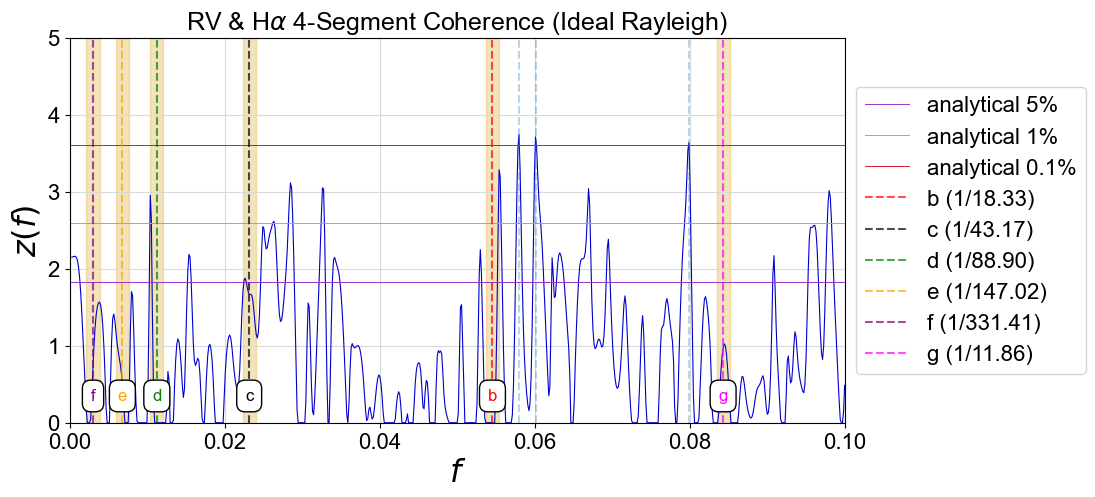

In [24]:
ideal_titles = [r"RV & H$\alpha$ 2-Segment Coherence (Ideal Rayleigh)",
                r"RV & H$\alpha$ 3-Segment Coherence (Ideal Rayleigh)",
                r"RV & H$\alpha$ 4-Segment Coherence (Ideal Rayleigh)"]

for bivar_objs, title, rayleigh in zip(bivar_obj_segs, ideal_titles, ideal_rayleigh):
    bivar_objs.coh_plot(transformed=True, show_theoretical_thresholds=True, show_boot_thresholds=False)
    plt.xlim(0, 0.1)
    plt.ylim(0, 5)
    plt.title(title, fontsize=title_font)
    rayleigh_shading(rayleigh, 7, -7)
    threshold_peaks(bivar_objs, "coh_prob_01", 0.000620)
    freq_vlines_text()
    freq_vlines() 

No file name provided. No new file created.


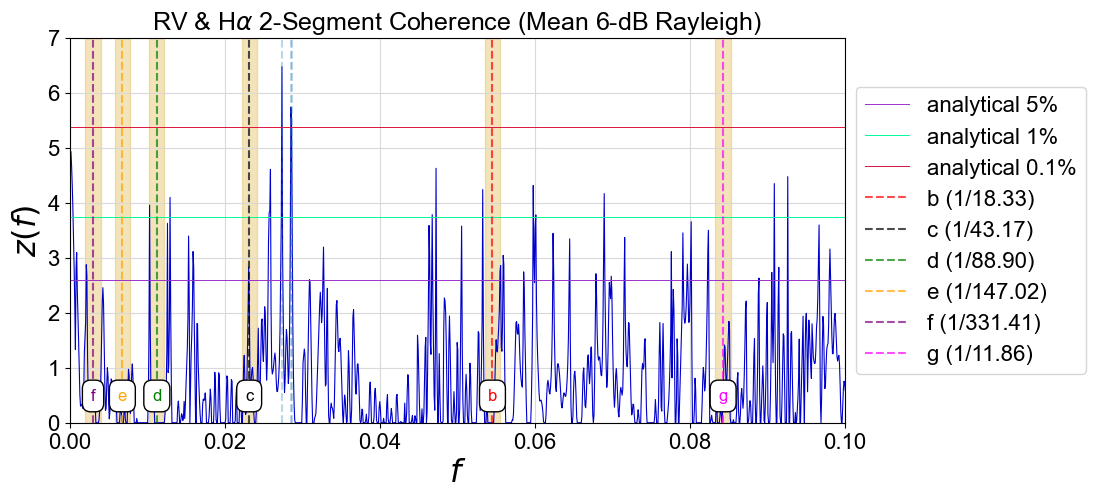

No file name provided. No new file created.


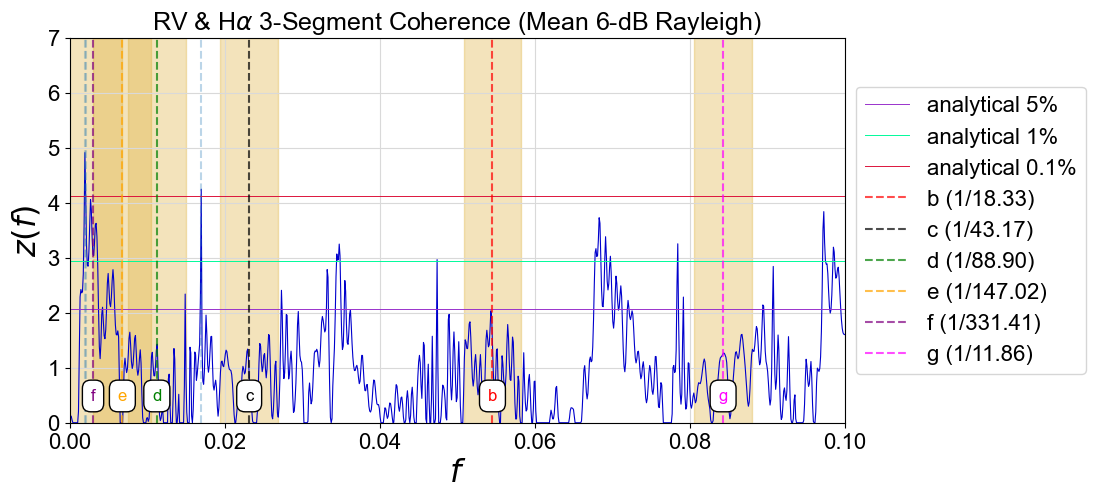

No file name provided. No new file created.


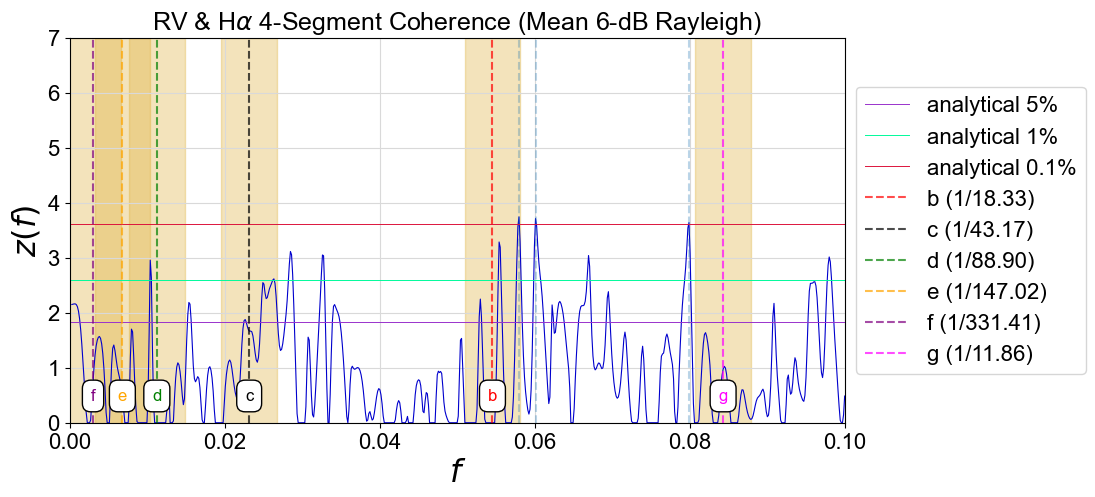

In [25]:
mean6db_titles = [r"RV & H$\alpha$ 2-Segment Coherence (Mean 6-dB Rayleigh)",
                  r"RV & H$\alpha$ 3-Segment Coherence (Mean 6-dB Rayleigh)",
                  r"RV & H$\alpha$ 4-Segment Coherence (Mean 6-dB Rayleigh)"]

for bivar_objs, title, rayleigh in zip(bivar_obj_segs, mean6db_titles, mean6db_rayleigh):
    bivar_objs.coh_plot(transformed=True, show_theoretical_thresholds=True, show_boot_thresholds=False)
    plt.xlim(0, 0.1)
    plt.ylim(0, 7)
    plt.title(title, fontsize=title_font)
    rayleigh_shading(rayleigh, 7, -7)
    threshold_peaks(bivar_objs, "coh_prob_01", 0.003729)
    freq_vlines_text()
    freq_vlines() 

### Examine the Welch's spectral window of RV & H$\alpha$

Since <tt>Bivariate</tt> object stores the data in two <tt>TimeSeries</tt> objects, <tt>x_series</tt> and <tt>y_series</tt>, you have access to all the <tt>TimeSeries</tt> methods. Here we use <tt>TimeSeries.spectral_window_Welch()</tt> to sanity-check our Welch's spectral window and make sure it has no huge sidelobes that can easily be misinterpreted as periodic signals. In these spectral window plots, we can see the signal for planet f present at a peak, with planet f being represented by the blue line, and a signal fo 365.25 days being represented by the red line. Using the rayleigh shading on the planet f signal's vertical line, we can see that each line is within a rayleigh resolution of each other within each segmentation, so these signals would not be distinguishable. This supports the idea that the planet f signal may be due to interference.

Half bandwidth: 0.003300
Welch average spectral window not saved to file
Half bandwidth: 0.001035
Welch average spectral window not saved to file
Half bandwidth: 0.001282
Welch average spectral window not saved to file
Half bandwidth: 0.003300
Welch average spectral window not saved to file
Half bandwidth: 0.001035
Welch average spectral window not saved to file
Half bandwidth: 0.001282
Welch average spectral window not saved to file


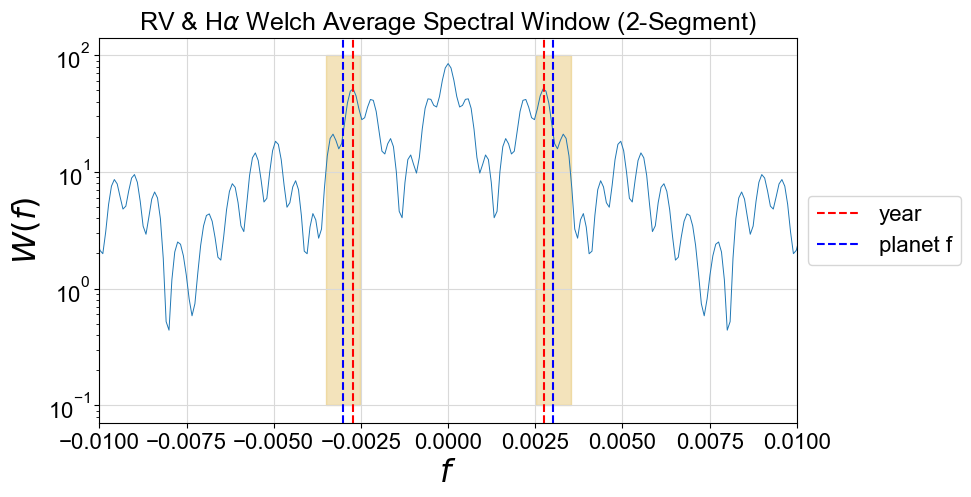

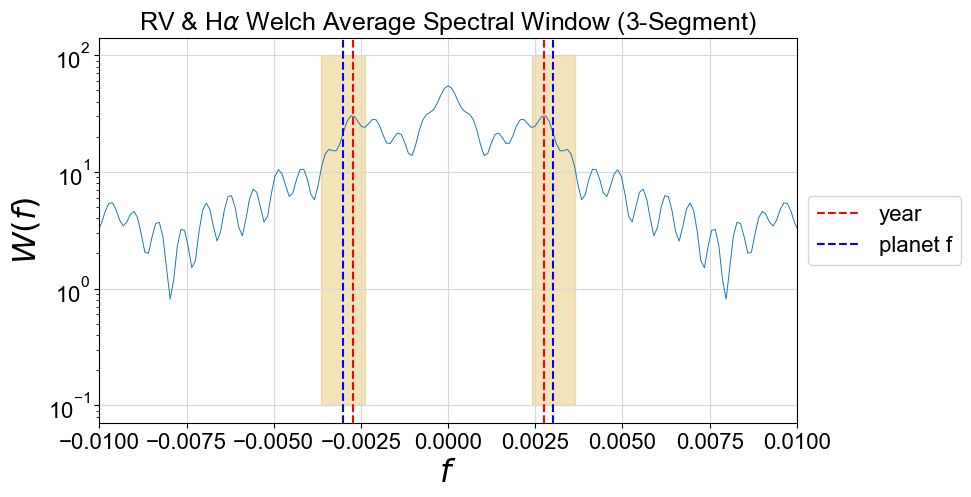

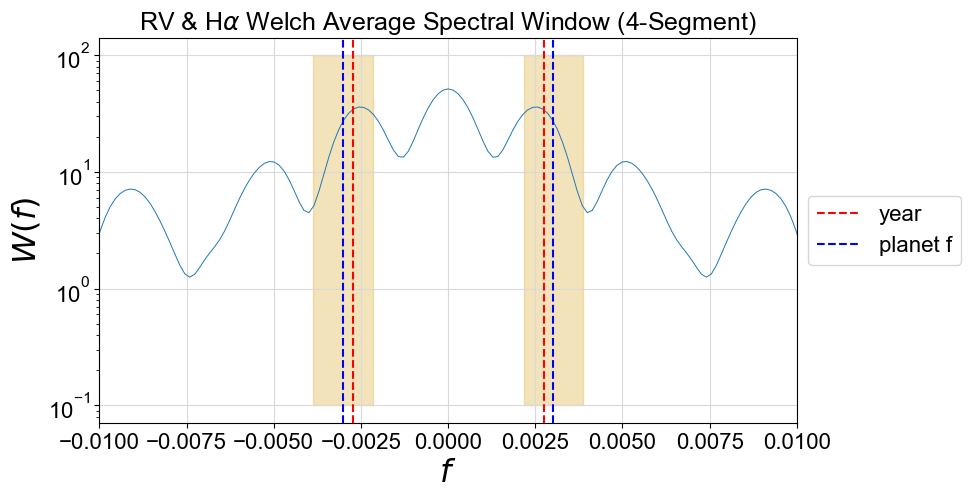

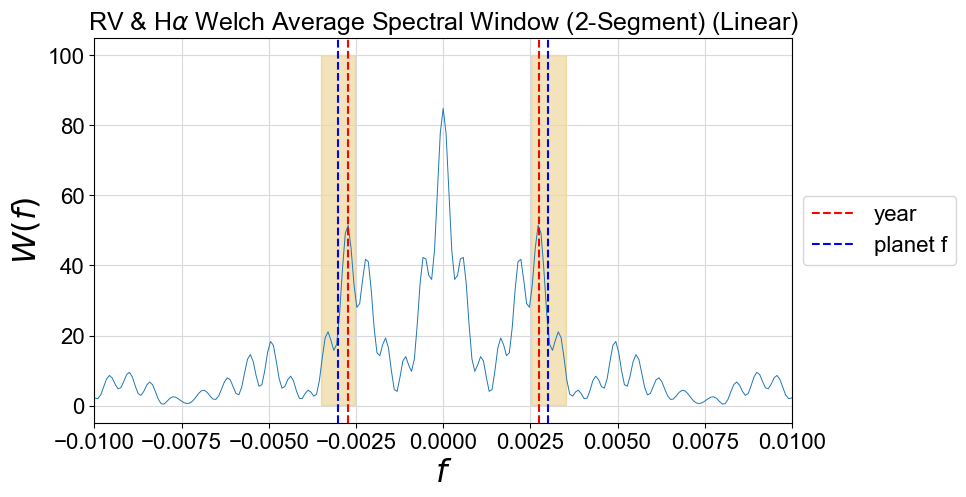

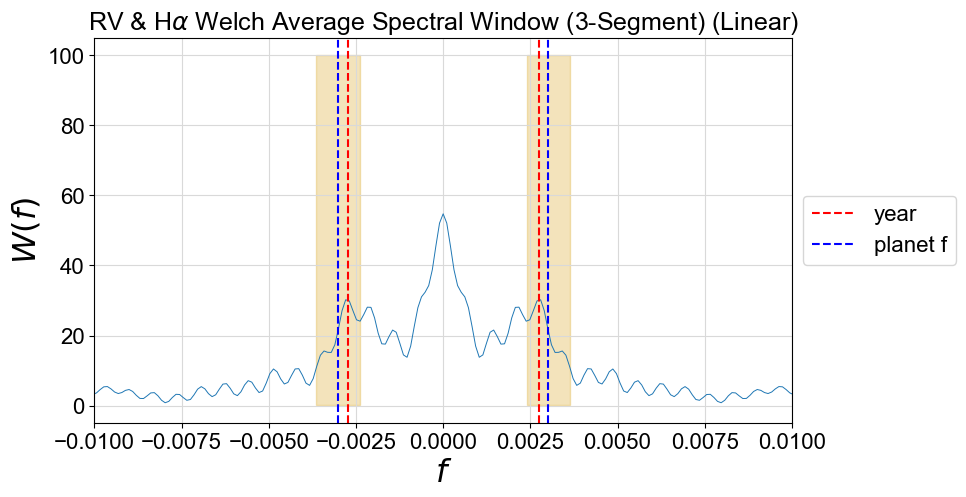

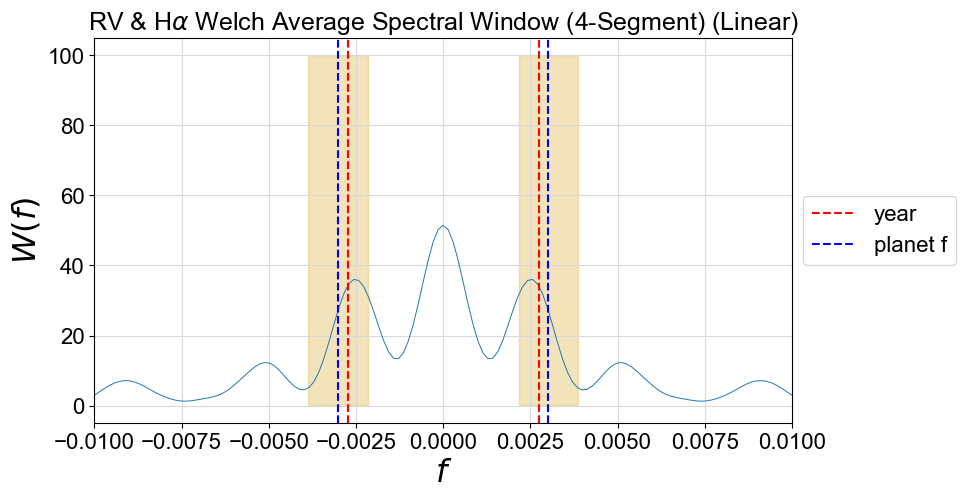

In [26]:
sw_titles = [r"RV & H$\alpha$ Welch Average Spectral Window (2-Segment)",
             r"RV & H$\alpha$ Welch Average Spectral Window (3-Segment)",
             r"RV & H$\alpha$ Welch Average Spectral Window (4-Segment)"]

sw_linear_titles = [r"RV & H$\alpha$ Welch Average Spectral Window (2-Segment) (Linear)",
                    r"RV & H$\alpha$ Welch Average Spectral Window (3-Segment) (Linear)",
                    r"RV & H$\alpha$ Welch Average Spectral Window (4-Segment) (Linear)"]

for bivar_objs, title, rayleigh in zip(bivar_obj_segs, sw_titles, ideal_rayleigh):
    bivar_objs.x_series.spectral_window_Welch()
    plt.axvline(x=1/365.25, linestyle='--', color='red', label='year')
    plt.axvline(x=-(1/365.25), linestyle='--', color='red')
    plt.axvline(x=1/pf, linestyle='--', color='blue', label='planet f')
    plt.axvline(x=-(1/pf), linestyle='--', color='blue')
    plt.fill_between([(1/pf) - rayleigh, (1/pf) + rayleigh], [1e-1,1e-1], [1e2, 1e2], color='goldenrod', alpha=0.3)
    plt.fill_between([-(1/pf) - rayleigh, -(1/pf) + rayleigh], [1e-1,1e-1], [1e2, 1e2], color='goldenrod', alpha=0.3)
    plt.xlim(-0.01, 0.01)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title, fontsize=title_font)
    
for bivar_objs, title, rayleigh in zip(bivar_obj_segs, sw_linear_titles, ideal_rayleigh):
    bivar_objs.x_series.spectral_window_Welch(yscale='linear')
    plt.axvline(x=1/365.25, linestyle='--', color='red', label='year')
    plt.axvline(x=-(1/365.25), linestyle='--', color='red')
    plt.axvline(x=1/pf, linestyle='--', color='blue', label='planet f')
    plt.axvline(x=-(1/pf), linestyle='--', color='blue')
    plt.fill_between([1/pf - rayleigh, 1/pf + rayleigh], [1e-1,1e-1], [1e2, 1e2], color='goldenrod', alpha=0.3)
    plt.fill_between([-(1/pf) - rayleigh, -(1/pf) + rayleigh], [1e-1,1e-1], [1e2, 1e2], color='goldenrod', alpha=0.3)
    plt.xlim(-0.01, 0.01)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title, fontsize=title_font)

### Plot both Welch's power spectrum estimates of RV & H$\alpha$

<tt>Bivariate.Welch_pow_plot()</tt> is a wrapper of <tt>TimeSeries.powplot(Welch=True)</tt>. The first three plots is of a Welch power plot of RV for each segmentation, while the last three plots is of a Welch power plot of H$\alpha$ for each segmentation.

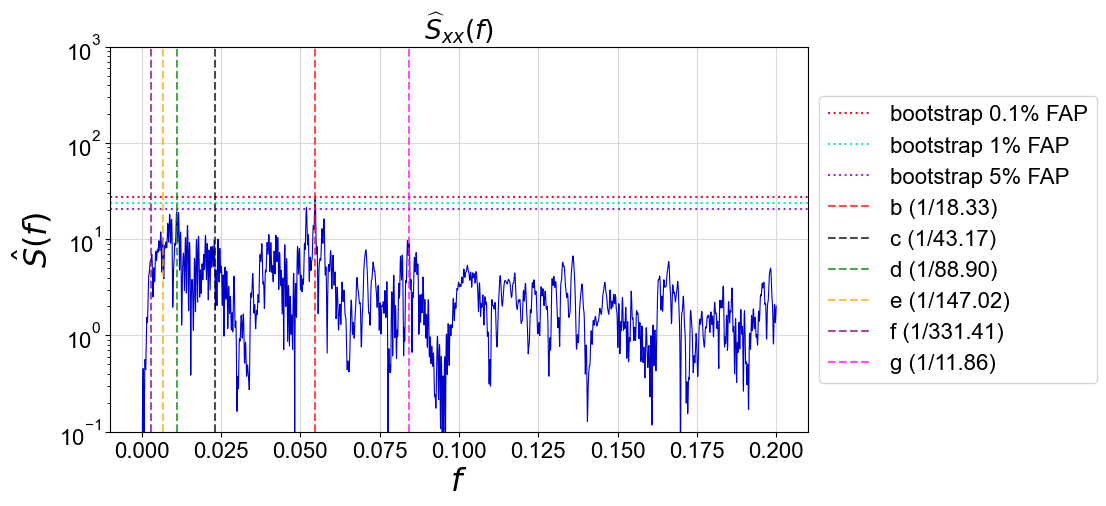

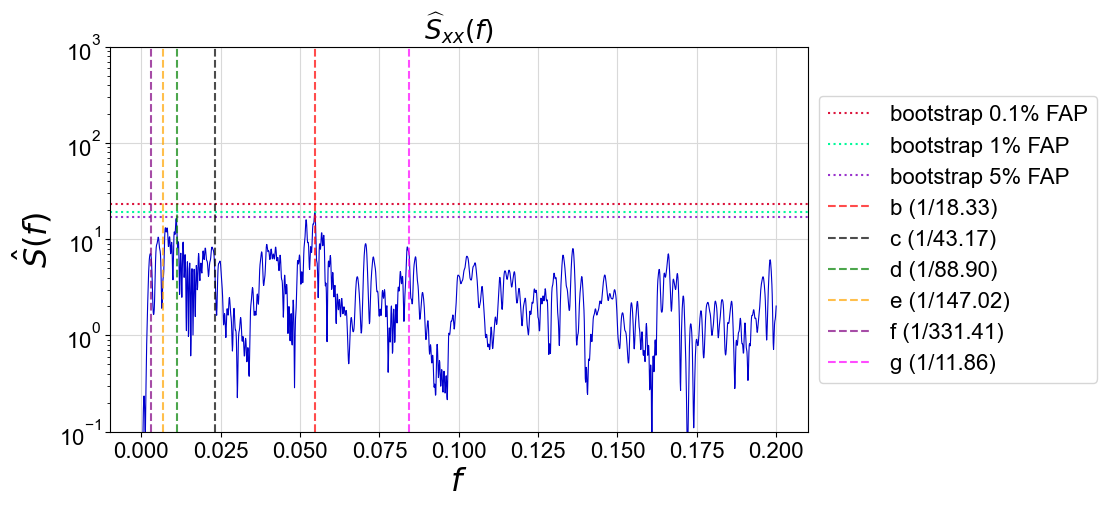

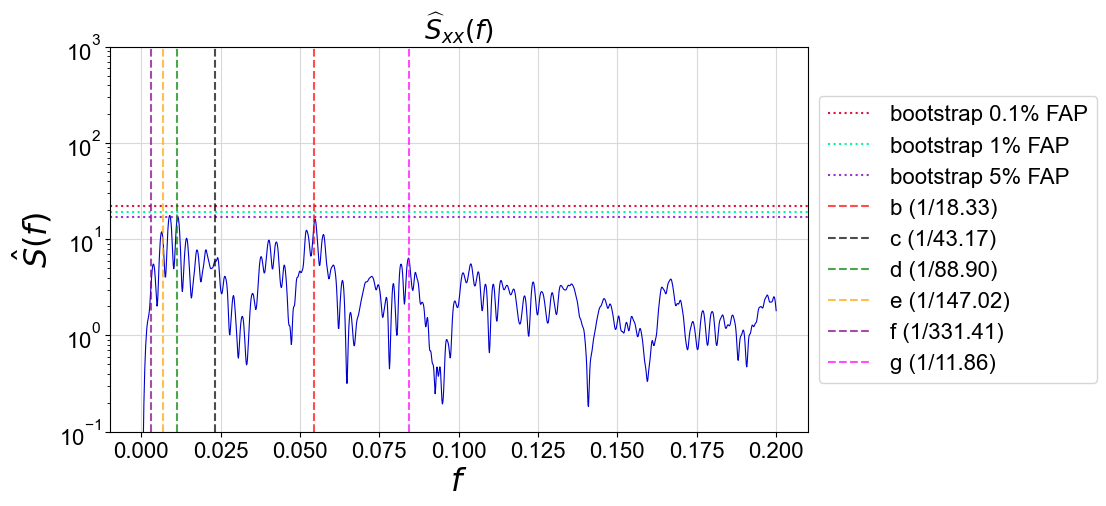

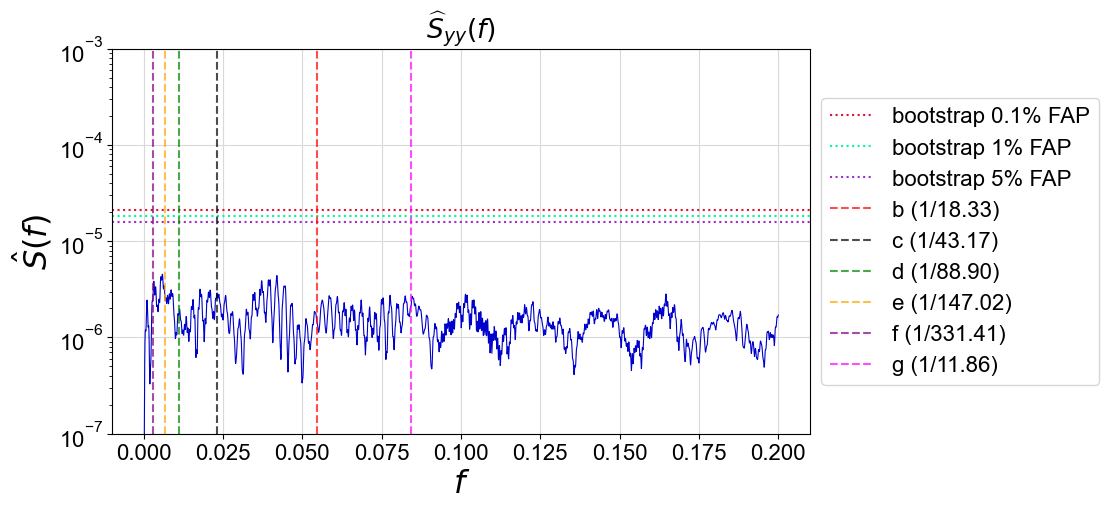

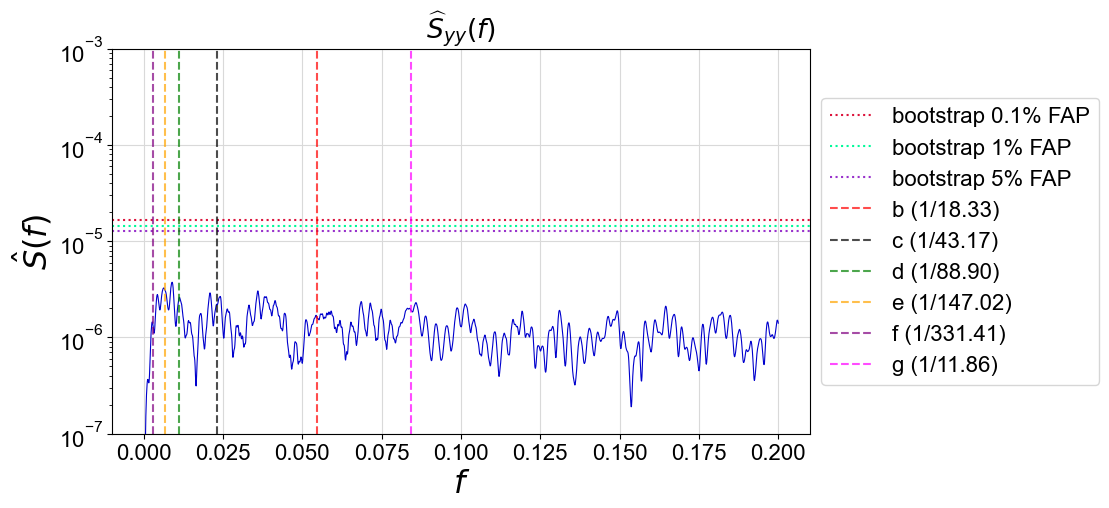

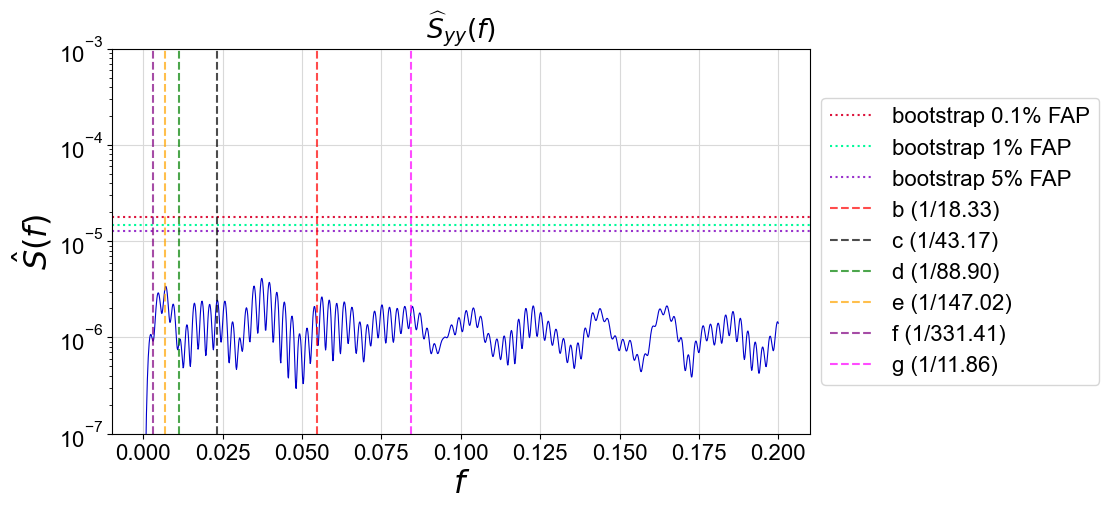

In [27]:
for bivar_objs in bivar_obj_segs:
    bivar_objs.Welch_pow_plot()
    plt.ylim(1e-1, 1e3)
    freq_vlines()
    
for bivar_objs in bivar_obj_segs:
    bivar_objs.Welch_pow_plot(x_or_y='y')
    plt.ylim(1e-7, 1e-3)
    freq_vlines()

### Plot RV power spectrum with a linear y-axis

This plot is similar to $\hat{S}_{x}(f)$, but with a linear y scale. This plot more easily shows the significance around the stellar signals of the planets.

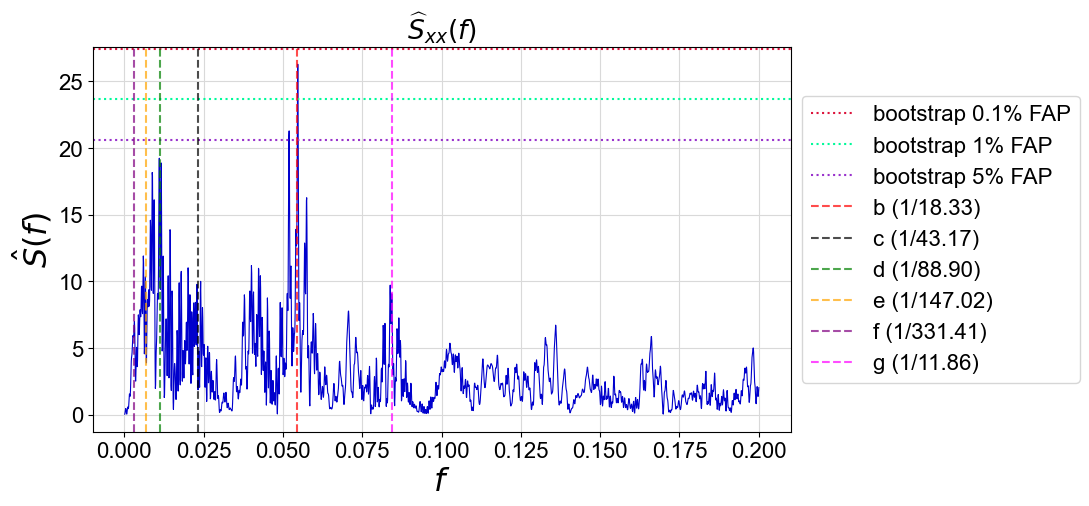

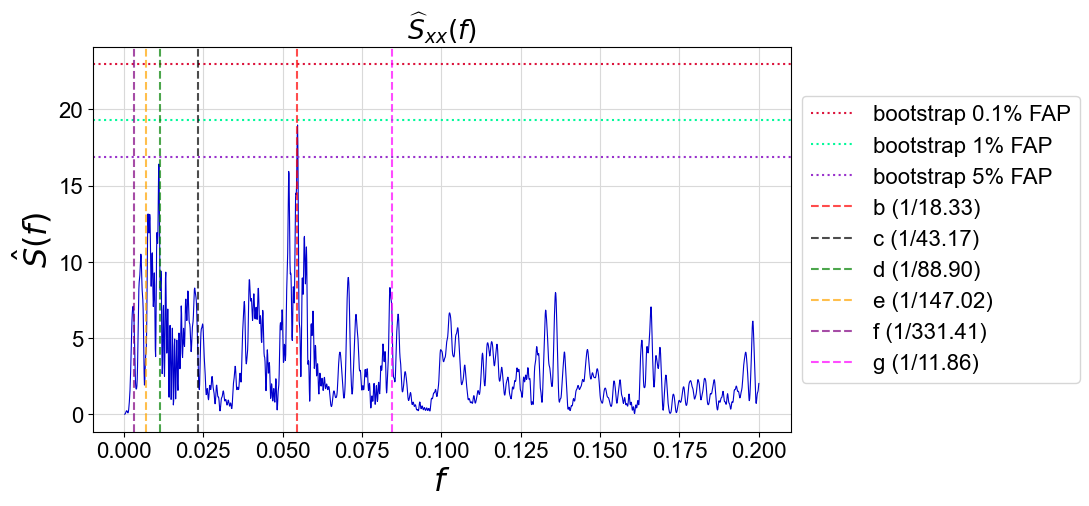

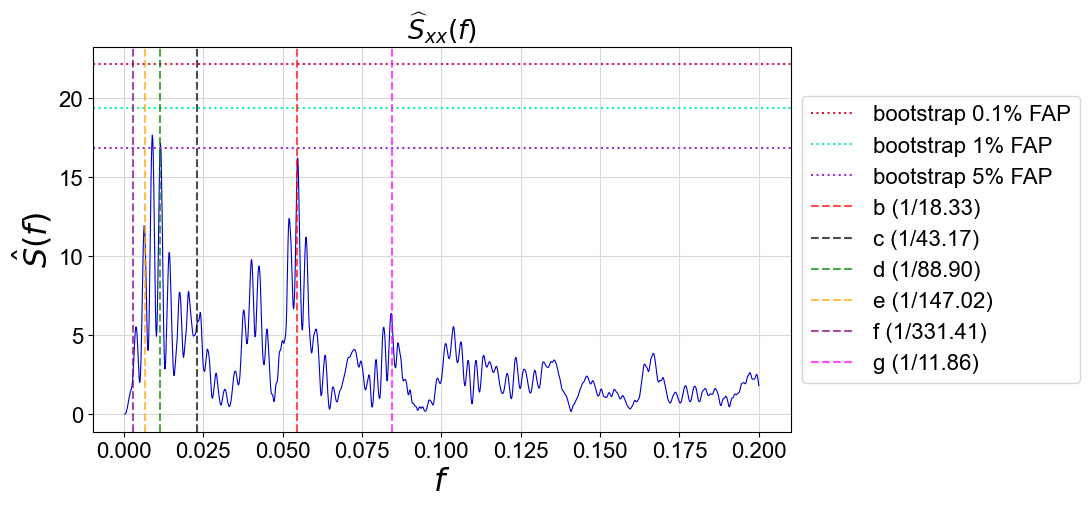

In [28]:
for bivar_objs in bivar_obj_segs:
    bivar_objs.Welch_pow_plot(yscale='linear')
    freq_vlines()

### Calculate <tt>astropy.timeseries.LombScargle</tt> periodograms from both time series

Here we specify the same frequency grid as in the previous analysis and use the power spectral density normalization so we can compare with the NWelch results, all of which are psd normalized. The zero frequency is responsible for the invalid value warning.

In [29]:
pow_ha_2segs = LombScargle(data['RJD'].to_numpy(), data['Halpha'].to_numpy(), normalization='psd').power(rv_ha_2segs.pow_coh_grid)
pow_ha_3segs = LombScargle(data['RJD'].to_numpy(), data['Halpha'].to_numpy(), normalization='psd').power(rv_ha_3segs.pow_coh_grid)
pow_ha_4segs = LombScargle(data['RJD'].to_numpy(), data['Halpha'].to_numpy(), normalization='psd').power(rv_ha_4segs.pow_coh_grid)
pow_rv_2segs = LombScargle(data['RJD'].to_numpy(), data['RV'].to_numpy(), normalization='psd').power(rv_ha_2segs.pow_coh_grid)
pow_rv_3segs = LombScargle(data['RJD'].to_numpy(), data['RV'].to_numpy(), normalization='psd').power(rv_ha_3segs.pow_coh_grid)
pow_rv_4segs = LombScargle(data['RJD'].to_numpy(), data['RV'].to_numpy(), normalization='psd').power(rv_ha_4segs.pow_coh_grid)

/Users/andrewandmatthewfonseca/anaconda3/lib/python3.10/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:131: RuntimeWarning: divide by zero encountered in divide
  power = YC * YC / CC + YS * YS / SS
/Users/andrewandmatthewfonseca/anaconda3/lib/python3.10/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:131: RuntimeWarning: invalid value encountered in divide
  power = YC * YC / CC + YS * YS / SS
/Users/andrewandmatthewfonseca/anaconda3/lib/python3.10/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:102: RuntimeWarning: invalid value encountered in divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))


### Rotation period measurement
Based on the highest peak in the H$\alpha$ Welch's periodogram, which is statistically significant, we can infer a rotation period.

In [30]:
frot_measured_2segs = rv_ha_2segs.y_series.Welch_powgrid[np.argmax(rv_ha_2segs.y_series.Welch_pow)]
frot_measured_3segs = rv_ha_3segs.y_series.Welch_powgrid[np.argmax(rv_ha_3segs.y_series.Welch_pow)]
frot_measured_4segs = rv_ha_4segs.y_series.Welch_powgrid[np.argmax(rv_ha_4segs.y_series.Welch_pow)]
print('Measured rotation period (2-Segment):', 1/frot_measured_2segs)
print('Measured rotation period (3-Segment):', 1/frot_measured_3segs)
print('Measured rotation period (4-Segment):', 1/frot_measured_4segs)
frot_array = [frot_measured_2segs, frot_measured_3segs, frot_measured_4segs]

Measured rotation period (2-Segment): 170.7042253521128
Measured rotation period (3-Segment): 111.0344827586209
Measured rotation period (4-Segment): 26.793893129770982


### Plots of each Welch's periodogram by itself using RV & H$\alpha$

Below are the plots for each Welch's periodogram for the activity indicator and the radial velocity. The plots from the first code cell are for the Welch's power spectrum estimate for the activity indicator for each segmentation. These plots have vertical lines placed at the measured rotation for its respective segmentation, which was taken from the previous section. The plots in the second code cell are for radial velocity. These have the same planet signal vertical lines as used in previous plots throughout the notebook.

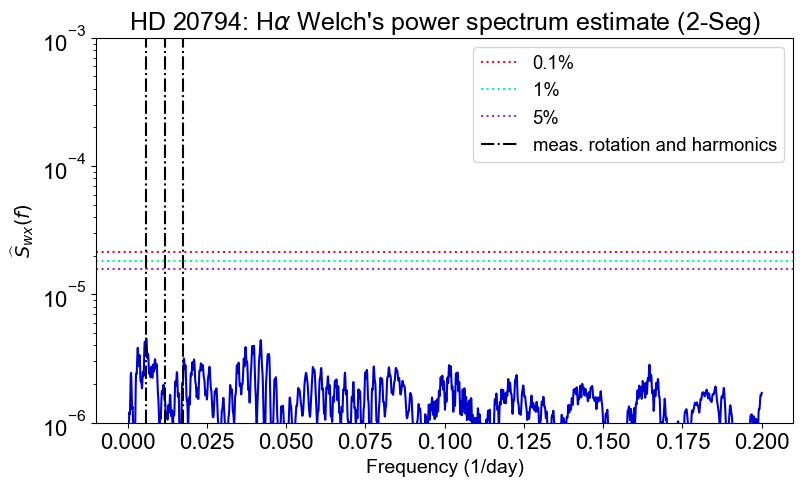

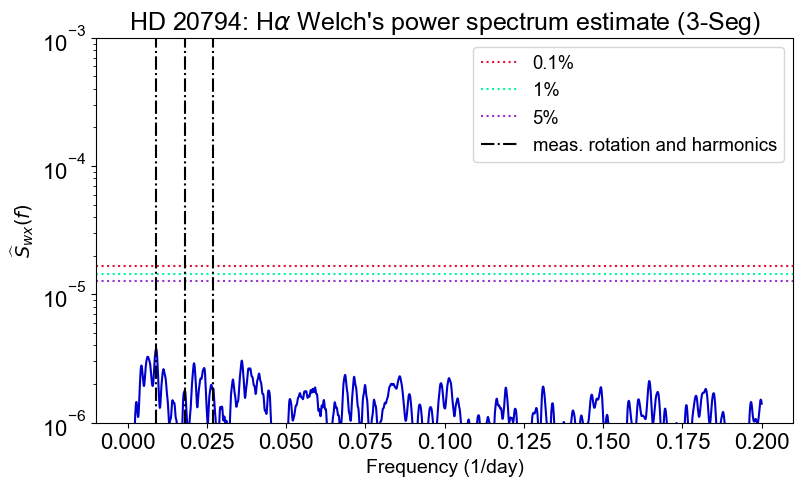

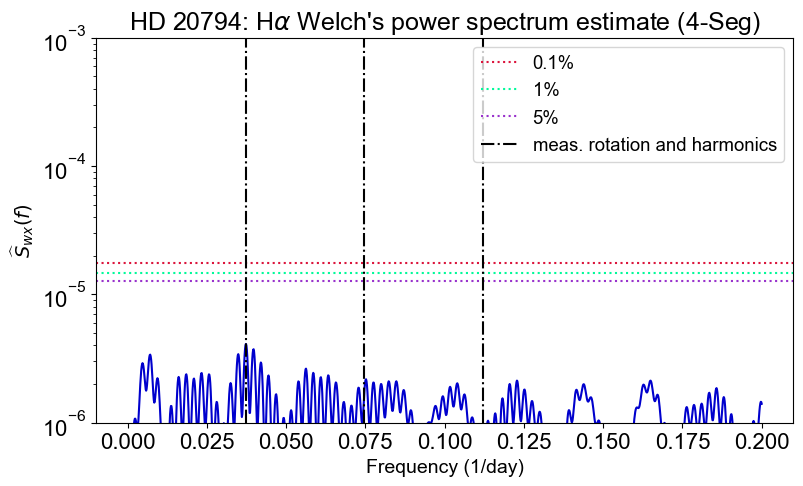

In [31]:
periodogram_titles = [r"HD 20794: H$\alpha$ Welch's power spectrum estimate (2-Seg)",
                      r"HD 20794: H$\alpha$ Welch's power spectrum estimate (3-Seg)",
                      r"HD 20794: H$\alpha$ Welch's power spectrum estimate (4-Seg)"]

for bivar_obj, frot, title_arr in zip(bivar_obj_segs, frot_array, periodogram_titles):
    plt.figure(figsize=figsize)
    plt.semilogy(bivar_obj.pow_coh_grid, bivar_obj.y_series.Welch_pow, color='mediumblue')
    plt.axhline(bivar_obj.ypow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1%')
    plt.axhline(bivar_obj.ypow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
    plt.axhline(bivar_obj.ypow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')
    
    for s in [frot, 2*frot]:
        plt.axvline(s, color='k', ls='-.')
    
    plt.ylim(1e-6, 1e-3)
    plt.axvline(3*frot, color='k', ls='-.', label='meas. rotation and harmonics')
    plt.xlabel('Frequency (1/day)', fontsize=label_font)
    plt.ylabel(r"$\widehat{S}_{wx}(f)$", fontsize=label_font)
    plt.title(title_arr, fontsize=title_font)
    plt.legend(loc='upper right', fontsize='small')

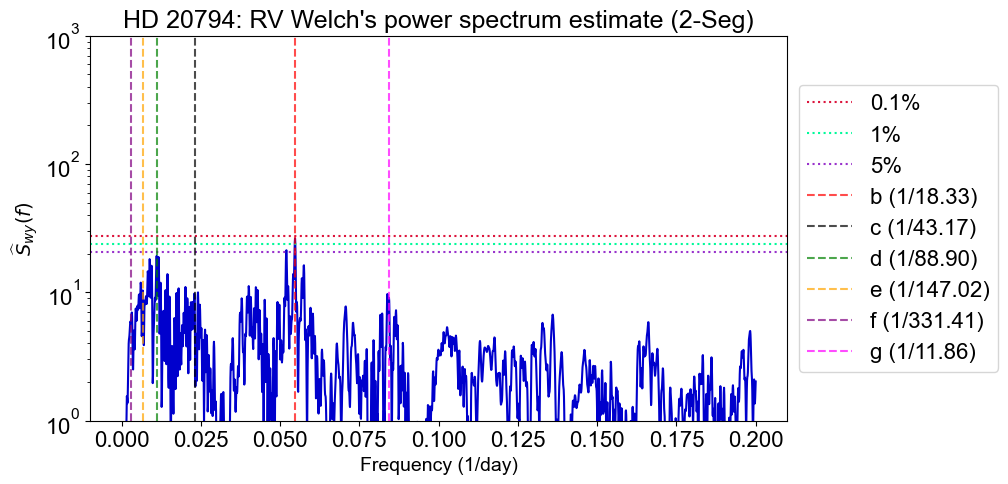

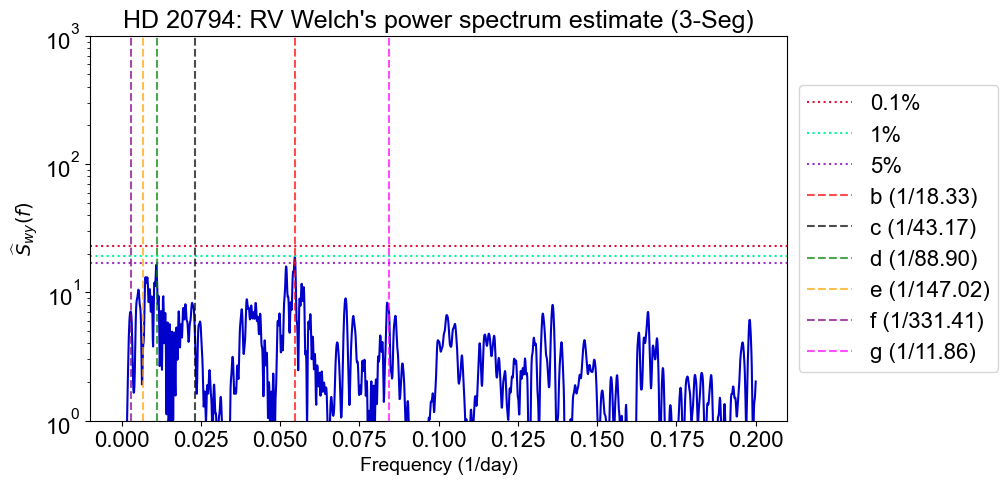

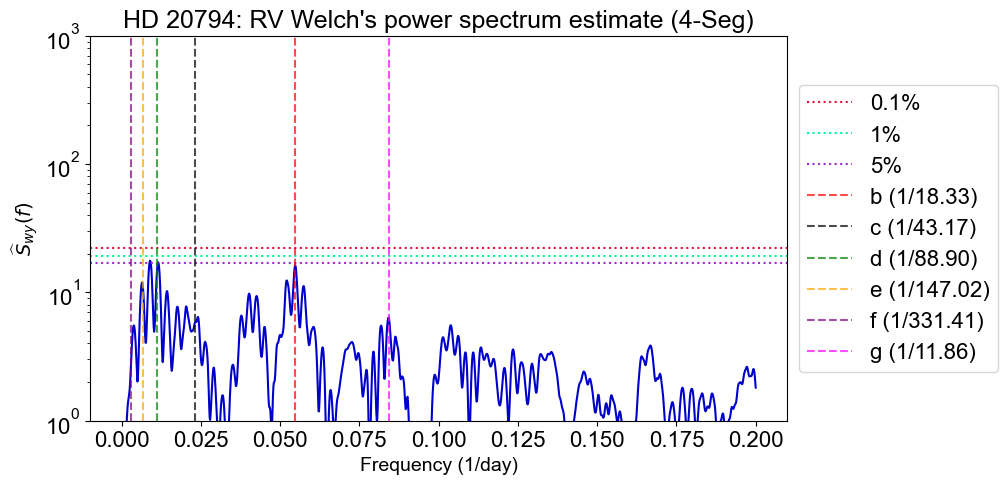

In [32]:
periodogram_titles = [r"HD 20794: RV Welch's power spectrum estimate (2-Seg)",
                      r"HD 20794: RV Welch's power spectrum estimate (3-Seg)",
                      r"HD 20794: RV Welch's power spectrum estimate (4-Seg)"]

for bivar_obj, title_arr in zip(bivar_obj_segs, periodogram_titles):
    plt.figure(figsize=figsize)
    plt.semilogy(bivar_obj.pow_coh_grid, bivar_obj.x_series.Welch_pow, color='mediumblue')
    plt.axhline(bivar_obj.xpow_Welch_false_alarm_01 , color='crimson', ls=':', label='0.1%')
    plt.axhline(bivar_obj.xpow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
    plt.axhline(bivar_obj.xpow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')
        
    plt.ylim(1, 1e3)
    plt.xlabel('Frequency (1/day)', fontsize=label_font)
    plt.ylabel(r"$\widehat{S}_{wy}(f)$", fontsize=label_font)
    plt.title(title_arr, fontsize=title_font)
    freq_vlines()

### Zero Mean Log Periodograms

These are log Lomb-Scargle periodograms with the mean removed. A $\chi^{2}_{2k}$ distribution is used to get a better examination of the planet signals within the zero mean log periodograms. We can see sigificant peaks for some of the planet signals within these zero mean log periodograms. Whitening was considered, but was not needed for these periodograms as they generally have a flat distribution.

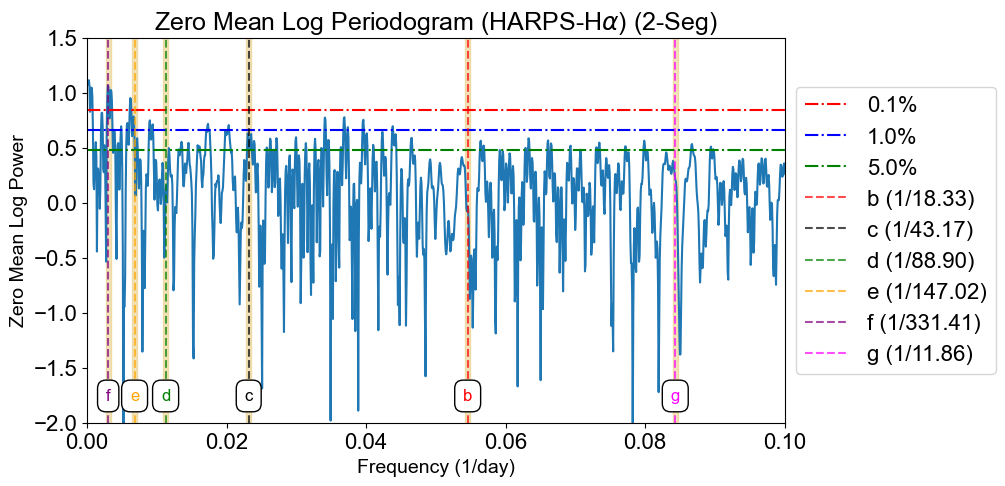

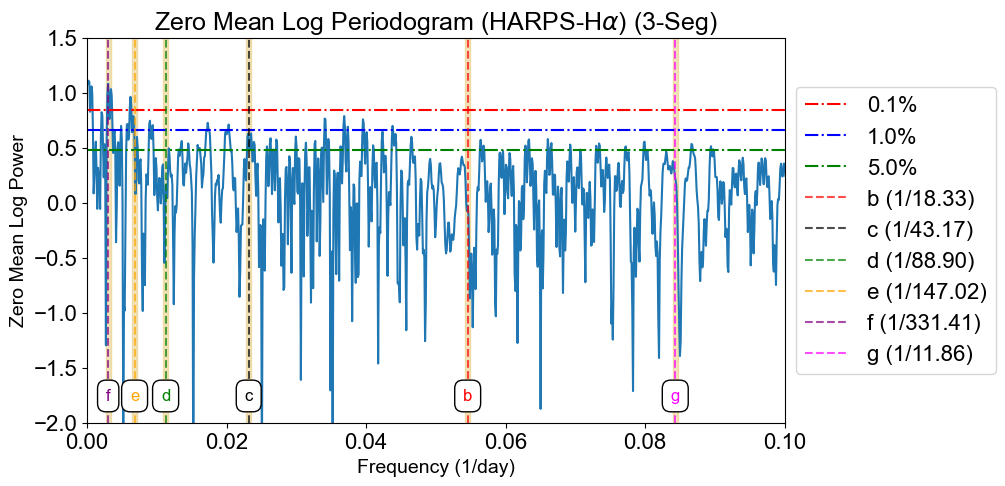

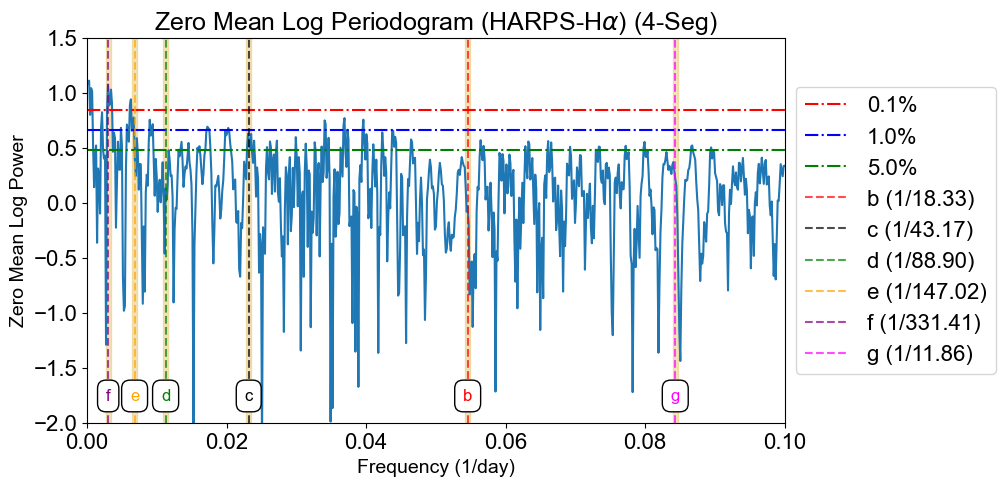

In [33]:
zml_titles = [r"Zero Mean Log Periodogram (HARPS-H$\alpha$) (2-Seg)",
              r"Zero Mean Log Periodogram (HARPS-H$\alpha$) (3-Seg)",
              r"Zero Mean Log Periodogram (HARPS-H$\alpha$) (4-Seg)"]

quantiles = [0.001, 0.01, 0.05]
df = 2
chi2_FALs = chi2.isf(quantiles, df) / 2
ls = LombScargle(data['RJD'].to_numpy(), data['Halpha'].to_numpy(), normalization='psd')
rayleigh_ls = 1/(data['RJD'].to_numpy()[-1] - data['RJD'].to_numpy()[0])
for bivar_obj, title_arr in zip(bivar_obj_segs, zml_titles):
    power = ls.power(bivar_obj.pow_coh_grid[1:])
    log_power = np.log10(power)
    mean_log_power = np.mean(log_power)
    log_power_subtracted = log_power - mean_log_power
    plt.figure(figsize=figsize)
    plt.plot(bivar_obj.pow_coh_grid[1:], log_power_subtracted)
    for i, q in enumerate(chi2_FALs):
        plt.axhline(np.log10(q), color=FAP_color_array[i], label=f"{100*quantiles[i]}"+"%", ls='-.',)
    plt.xlim(0,0.1)
    plt.ylim(-2,1.5)
    plt.title(title_arr, fontsize=title_font)
    plt.xlabel('Frequency (1/day)', fontsize=label_font)
    plt.ylabel('Zero Mean Log Power', fontsize=label_font)
    rayleigh_shading(rayleigh_ls, 7, -7)
    freq_vlines_text()
    freq_vlines()